#### Import Libraries

In [15]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.chat_models import ChatOpenAI  # or another model
from langchain.chains import LLMChain

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

import os
from dotenv import load_dotenv
import re

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
groq_api_key=os.environ['GROQ_API_KEY']


# Check if the keys are correctly loaded
assert os.environ["LANGCHAIN_API_KEY"], "LANGCHAIN_API_KEY is not set."
assert groq_api_key, "GROQ_API_KEY is not set."


#Extract data from the PDF
def load_pdf(data):
    loader=PyPDFDirectoryLoader(data,
                    glob="*.pdf")
    
    documents = loader.load()

    return documents



documents = load_pdf('./data')

documents


# Define a cleaning function
def clean_text(text):
    # Remove newlines
    text = re.sub(r'\n', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove timestamps
    text = re.sub(r'\d+/\d+/\d+\s+\d+:\d+:\d+\s+[AP]M', '', text)
    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()
    # Strip leading and trailing whitespaces
    text = text.strip()
    return text



# Clean the page_content of each document
for document in documents:
    document.page_content = clean_text(document.page_content)

# Split documents into smaller chunks
text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
final_documents=text_splitter.split_documents(documents)
print(final_documents[50].page_content)

len(final_documents)

# #download embedding model
# huggingface_embeddings=HuggingFaceBgeEmbeddings(
#     model_name="sentence-transformers/all-MiniLM-l6-v2"      # BAAI/bge-small-en-v1.5
# )
from langchain.embeddings import HuggingFaceEmbeddings

# Correct way to load HuggingFace embeddings
huggingface_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


embeddings=OllamaEmbeddings()



#database = FAISS.from_documents(final_documents, huggingface_embeddings)
try:
    database = FAISS.from_documents(final_documents, huggingface_embeddings)
except ImportError as e:
    print("Error importing FAISS:", e)
    print("Ensure faiss-cpu or faiss-gpu is installed in the current environment.")
    raise

database


llm=ChatGroq(groq_api_key=groq_api_key,
             model_name="llama3-70b-8192")


prompt = ChatPromptTemplate.from_template("""
Hello! You are an exceptionally knowledgeable lawyer with extensive expertise 
in various areas of Indian law, including but not limited to civil litigation, 
criminal defense, corporate law, family law, and real estate law. You have a 
deep understanding of the Indian Penal Code (IPC) and other pertinent Indian 
legal frameworks. Your role is to provide accurate, insightful legal counsel 
on the rights and obligations of clients, interpret and apply laws to specific 
situations, and draft legal documents as needed. You are adept at representing 
clients in both criminal and civil trials, presenting evidence, and formulating 
strong arguments.
If you don't know the answer, just say that you don't know, don't 
try to make up an answer.
                                          
<context>
{context}
</context>
Question: {input}

Only return the helpful answer below and nothing else.
Helpful answer:""")


## Create Stuff Docment Chain
document_chain=create_stuff_documents_chain(llm,prompt)

retriever=database.as_retriever()
retriever

retrieval_chain=create_retrieval_chain(retriever,document_chain)
retrieval_chain

 #response=retrieval_chain.invoke({"input":" If someone got rob, then what is the IPC section should apply if the robber is under 18?"})
response=retrieval_chain.invoke({"input":" If someone is caught trespassing on private property, which IPC section should apply if the offender is a minor?"})
#response=retrieval_chain.invoke({"input":" What IPC section is applicable if a minor is involved in a case of assault causing minor injuries??"})


# Define a function for text summarization
def summarize_text(text):
    # Load the summarization model and tokenizer
    model_name = "sshleifer/distilbart-cnn-12-6"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    summarization_pipeline = pipeline("summarization", model=model, tokenizer=tokenizer)
    
    # Summarize the text
    summarized_text = summarization_pipeline(text, max_length=150, min_length=30, do_sample=False)
    return summarized_text[0]['summary_text']

summarized_answer = summarize_text(response['answer'])
# Print the summarized answer
print(summarized_answer)

summarized_answer



incorrect startxref pointer(1)
parsing for Object Streams


28 372A. Power of the President to adapt laws. 373. Power of President to make order in respect of persons under preventive detention in certain cases. 374. Provisions as to Judges of the Federal Court and proceedings pending in the Federal Court or before His Majesty in Council. 375. Courts, authorities and officers to continue to function subject to the provisions of the Constitution. 376. Provisions as to Judges of High Courts. 377. Provisions as to Comptroller and Auditor-General of India. 378. Provisions as to Public Service Commissions. 378A. Special provision as to duration of Andhra Pradesh Legislative Assembly. [379. Provisions as to provisional Parliament and the Speaker and Deputy Speaker thereof.Omitted.] [380. Provision as to President. Omitted.] [381. Council of Ministers of the President.Omitted.] [382. Provisions as to provisional Legislatures for States in Part A of the First Schedule. -- Omitted.] [383. Provision as to Governors of Provinces. -- Omitted.] [384.


C:\Users\jagde\AppData\Local\Temp\ipykernel_29260\3650962787.py:81: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  huggingface_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
d:\ChatBot\Indian-Law-Chatbot\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jagde\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be 

 Section 441 of the Indian Penal Code (IPC) applies to criminal trespass, and it does not differentiate between adults and minors . The Juvenile Justice (Care and Protection of Children) Act, 2015, would also come into play, and the minor's age would be a relevant factor .


" Section 441 of the Indian Penal Code (IPC) applies to criminal trespass, and it does not differentiate between adults and minors . The Juvenile Justice (Care and Protection of Children) Act, 2015, would also come into play, and the minor's age would be a relevant factor ."

In [6]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

import os
from dotenv import load_dotenv
import re

# Load environment variables
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

# Ensure API keys are loaded
assert os.environ["LANGCHAIN_API_KEY"], "LANGCHAIN_API_KEY is not set."
assert groq_api_key, "GROQ_API_KEY is not set."

# Function to load and extract text from PDFs
def load_pdf(data):
    loader = PyPDFDirectoryLoader(data, glob="*.pdf")
    documents = loader.load()
    return documents

documents = load_pdf('./data')

# Enhanced text cleaning function
def clean_text(text):
    # Remove special characters but preserve legal citations and multilingual text
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s\u0900-\u097F\u0980-\u09FF\u0A00-\u0A7F\u0A80-\u0AFF\u0B00-\u0B7F\u0B80-\u0BFF\u0C00-\u0C7F\u0C80-\u0CFF\u0D00-\u0D7F]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Preserve legal citations
    text = re.sub(r'(Section|धारा)\s(\d+[A-Z]*)', r'\1 \2', text)
    return text.strip()

# Clean document content
for document in documents:
    document.page_content = clean_text(document.page_content)

# Define custom separators that preserve legal citations
custom_separators = [
    "\n\n", 
    "\n", 
    "।",  # Hindi full stop
    "।",  # Hindi full stop
    " ", 
    ""
]

# Create text splitter with custom separators
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=custom_separators,
    length_function=len
)

final_documents = text_splitter.split_documents(documents)

# Load multilingual embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)

# Create FAISS vector store
try:
    database = FAISS.from_documents(final_documents, embeddings)
except ImportError as e:
    print("Error importing FAISS:", e)
    print("Ensure faiss-cpu or faiss-gpu is installed in the current environment.")
    raise

# Define the Chat Model (LLM)
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama3-70b-8192",
    temperature=0.3  # Lower temperature for more factual responses
)

# Enhanced prompt template for legal assistance
system_template = """
You are an expert Indian lawyer with deep knowledge of IPC, CrPC, Constitution, and other Indian laws.
You must:
1. Provide accurate legal advice in the language of the question (Hindi, English, etc.)
2. Always cite relevant sections of law from the provided context
3. If context doesn't contain answer, say "I don't know" in the question's language
4. For Hindi responses, include relevant IPC/CrPC sections in both Hindi and English
5. Structure answers with: Relevant Law -> Application -> Conclusion

Current conversation:
{chat_history}

Context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template("{question}")
])

# Memory for conversation history
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key='answer'
)

# Create retrieval chain
retriever = database.as_retriever(search_kwargs={"k": 4})
retrieval_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    combine_docs_chain_kwargs={"prompt": prompt},
    return_source_documents=True
)

def format_response(response, question_language):
    answer = response['answer']
    sources = response['source_documents']
    
    # Extract relevant sections from sources
    cited_sections = set()
    for doc in sources:
        content = doc.page_content
        # Match legal citations in both English and Hindi
        sections = re.findall(r'(Section|धारा)\s(\d+[A-Z]*)', content)
        for section in sections:
            cited_sections.add(f"{section[0]} {section[1]}")
    
    # Format the response based on language
    if any(char in '\u0900-\u097F' for char in question_language):  # Detect Hindi
        formatted_response = f"कानूनी सलाह:\n{answer}\n\nसंदर्भ धाराएँ:\n"
        for section in cited_sections:
            if "Section" in section:
                formatted_response += f"- {section} (आईपीसी)\n"
            else:
                formatted_response += f"- {section}\n"
        formatted_response += "\nनोट: यह सामान्य कानूनी जानकारी है, विशिष्ट मामलों के लिए वकील से सलाह लें।"
    else:
        formatted_response = f"Legal Advice:\n{answer}\n\nRelevant Sections:\n"
        for section in cited_sections:
            formatted_response += f"- {section}\n"
        formatted_response += "\nNote: This is general legal information, consult a lawyer for specific cases."
    
    return formatted_response

# Example usage
questions = [
    "किसी निजी संपत्ति पर अतिक्रमण करने वाले नाबालिग के लिए आईपीसी की कौन सी धारा लागू होगी?",
    "What is the punishment for cheating under IPC?",
    "महिलाओं के खिलाफ घरेलू हिंसा के लिए कौन सा कानून लागू होता है?"
]

for question in questions:
    # Detect question language
    lang = "Hindi" if any(char in '\u0900-\u097F' for char in question) else "English"
    
    response = retrieval_chain.invoke({"question": question})
    formatted_answer = format_response(response, question)
    
    print("\n" + "="*50)
    print(f"Question ({lang}): {question}")
    print("-"*50)
    print(formatted_answer)
    print("="*50 + "\n")

incorrect startxref pointer(1)
parsing for Object Streams
d:\ChatBot\Indian-Law-Chatbot\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jagde\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



Question (English): किसी निजी संपत्ति पर अतिक्रमण करने वाले नाबालिग के लिए आईपीसी की कौन सी धारा लागू होगी?
--------------------------------------------------
Legal Advice:
Relevant Law -> Application -> Conclusion

Relevant Law: Section 441 of the Indian Penal Code (IPC) defines Criminal Trespass as "Whoever enters into or upon property in possession of another with intent to commit an offence or to intimidate, insult or annoy any person in possession of such property or having lawfully entered into or upon such property unlawfully remains there with intent thereby to intimidate, insult or annoy any such person or with intent to commit an offence."

Application: In this case, a minor (नाबालिग) has committed criminal trespass on private property (निजी संपत्ति). Since the minor has entered into someone else's property with the intention of committing an offence or annoying the person in possession of the property, Section 441 of IPC is applicable.

Conclusion: Therefore, the relevant s

In [2]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate
import os
from dotenv import load_dotenv
import re

# Load environment variables
load_dotenv()

# Configuration
PDF_DIR = './data'
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
LLM_MODEL = "llama3-70b-8192"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY", "")
groq_api_key = os.getenv("GROQ_API_KEY", "")

# Validate environment
if not os.environ.get("LANGCHAIN_API_KEY"):
    raise ValueError("LANGCHAIN_API_KEY is not set in .env file")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY is not set in .env file")
if not os.path.exists(PDF_DIR):
    raise FileNotFoundError(f"PDF directory not found: {PDF_DIR}")

# Document processing
try:
    loader = PyPDFDirectoryLoader(PDF_DIR)
    documents = loader.load()
    
    def clean_text(text):
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^\w\s\u0900-\u097F]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(Section|धारा)\s(\d+[A-Z]*)', r'\1 \2', text)
        return text.strip()
    
    for doc in documents:
        doc.page_content = clean_text(doc.page_content)
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len
    )
    split_docs = text_splitter.split_documents(documents)

except Exception as e:
    print(f"Document processing error: {str(e)}")
    raise

# Initialize components
try:
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
    db = FAISS.from_documents(split_docs, embeddings)
    
    llm = ChatGroq(
        groq_api_key=groq_api_key,
        model_name=LLM_MODEL,
        temperature=0.3
    )
    
    template = """Answer the question based on the context below in the same language as the question.
    If you don't know the answer, say you don't know in the question's language.
    Context: {context}
    Question: {question}
    Answer:"""
    
    QA_PROMPT = PromptTemplate.from_template(template)
    
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        return_messages=True,
        output_key='answer'
    )
    
    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=db.as_retriever(search_kwargs={"k": 3}),
        memory=memory,
        combine_docs_chain_kwargs={"prompt": QA_PROMPT},
        return_source_documents=True
    )

except Exception as e:
    print(f"Initialization error: {str(e)}")
    raise

# Response formatting
def format_response(response, is_hindi):
    try:
        answer = response['answer']
        answer = re.sub(r'Note:.*|नोट:.*', '', answer, flags=re.DOTALL)
        
        sections = set()
        for doc in response['source_documents']:
            found = re.findall(r'(Section|धारा)\s(\d+[A-Z]*)', doc.page_content)
            sections.update(f"{s[0]} {s[1]}" for s in found)
        
        if sections:
            citations = "\nसंदर्भ धाराएँ:\n" + "\n".join(f"- {s}" for s in sections) if is_hindi else \
                       "\nRelevant Sections:\n" + "\n".join(f"- {s}" for s in sections)
            answer += citations
        
        return answer
    except Exception as e:
        return f"Error formatting response: {str(e)}"

# Main interaction loop
print("\n" + "="*60)
print("भारतीय कानून सहायक | Indian Law Assistant".center(60))
print("="*60)
print("Type 'exit' or 'बाहर' to quit\n")

while True:
    try:
        question = input("आपका प्रश्न / Your question: ").strip()
        if not question:
            continue
        if question.lower() in ['exit', 'बाहर']:
            print("Exiting...")
            break
        
        is_hindi = any(char in '\u0900-\u097F' for char in question)
        response = qa_chain({"question": question})
        
        print("\n" + "="*80)
        print("कानूनी सलाह:" if is_hindi else "LEGAL ADVICE")
        print("-"*80)
        print(format_response(response, is_hindi))
        print("="*80 + "\n")
        
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except Exception as e:
        print(f"\nError processing question: {str(e)}")

incorrect startxref pointer(1)
parsing for Object Streams



         भारतीय कानून सहायक | Indian Law Assistant          
Type 'exit' or 'बाहर' to quit


LEGAL ADVICE
--------------------------------------------------------------------------------
I don't know.
Relevant Sections:
- Section 380


LEGAL ADVICE
--------------------------------------------------------------------------------
हाँ, आपके पास संपत्ति पर अवैध निर्माण के लिए कानूनी उपाय हैं। आप दोषी ट्रेसपास के तहत मामला दर्ज करा सकते हैं, जिसके लिए 7 साल की सजा या जुर्माना या दोनों हो सकते हैं।
Relevant Sections:
- Section 481
- Section 478
- Section 480
- Section 479


LEGAL ADVICE
--------------------------------------------------------------------------------
मैं नहीं जानता। (I don't know.)

The provided context appears to be related to the Indian Penal Code and discusses various sections related to counterfeiting, forgery, and punishment for such offenses. It does not mention anything about consumer protection laws or filing complaints against defective products. Therefore, I couldn

In [3]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate
import os
from dotenv import load_dotenv
import re

# Load environment variables
load_dotenv()

# Configuration
PDF_DIR = './data'
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
LLM_MODEL = "llama3-70b-8192"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY", "")
groq_api_key = os.getenv("GROQ_API_KEY", "")

# Validate environment
if not os.environ.get("LANGCHAIN_API_KEY"):
    raise ValueError("LANGCHAIN_API_KEY is not set in .env file")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY is not set in .env file")
if not os.path.exists(PDF_DIR):
    raise FileNotFoundError(f"PDF directory not found: {PDF_DIR}")

# Document processing
try:
    loader = PyPDFDirectoryLoader(PDF_DIR)
    documents = loader.load()
    
    def clean_text(text):
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^\w\s\u0900-\u097F।॥]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(Section|धारा|कलम)\s(\d+[A-Z]*)', r'\1 \2', text)
        return text.strip()
    
    for doc in documents:
        doc.page_content = clean_text(doc.page_content)
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len
    )
    split_docs = text_splitter.split_documents(documents)

except Exception as e:
    print(f"Document processing error: {str(e)}")
    raise

# Initialize components
try:
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
    db = FAISS.from_documents(split_docs, embeddings)
    
    llm = ChatGroq(
        groq_api_key=groq_api_key,
        model_name=LLM_MODEL,
        temperature=0.3
    )
    
    # Modified prompt template that embeds language in the question
    template = """Answer the following question in {language} language.
    Provide a detailed response with:
    1. Relevant legal provisions (cite sections)
    2. Step-by-step procedure
    3. Required documents
    4. Contact information for relevant authorities
    
    Context: {context}
    Question: {question}
    
    Answer in {language}:"""
    
    QA_PROMPT = PromptTemplate(
        input_variables=["context", "question"],
        partial_variables={"language": "English"},  # Default value
        template=template
    )
    
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        return_messages=True,
        output_key='answer'
    )
    
    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=db.as_retriever(search_kwargs={"k": 5}),
        memory=memory,
        combine_docs_chain_kwargs={"prompt": QA_PROMPT},
        return_source_documents=True
    )

except Exception as e:
    print(f"Initialization error: {str(e)}")
    raise

# Improved language detection
def detect_language(text):
    if re.search(r'[\u0900-\u097F]', text):
        # Check for Marathi specific words
        marathi_words = ['माझे', 'मराठी', 'कशी', 'काय', 'कलम']
        if any(word in text.lower() for word in marathi_words):
            return 'Marathi'
        return 'Hindi'
    return 'English'

def format_response(response, language):
    try:
        answer = response['answer']
        
        # Ensure the response is in the correct language
        if language == 'English' and re.search(r'[\u0900-\u097F]', answer):
            answer = "Response not in English as expected. Please try again."
        elif language in ['Hindi', 'Marathi'] and not re.search(r'[\u0900-\u097F]', answer):
            answer = "उत्तर अपेक्षित भाषा में प्राप्त नहीं हुआ। कृपया पुनः प्रयास करें।" if language == 'Hindi' else "उत्तर अपेक्षित भाषेत मिळाले नाही. कृपया पुन्हा प्रयत्न करा."
        
        # Extract sections
        sections = set()
        for doc in response['source_documents']:
            found = re.findall(r'(Section|धारा|कलम)\s(\d+[A-Z]*)', doc.page_content)
            sections.update(f"{s[0]} {s[1]}" for s in found)
        
        # Add references
        if sections:
            if language == 'Hindi':
                answer += "\n\nसंबंधित कानूनी प्रावधान:\n" + "\n".join(f"- {s}" for s in sorted(sections))
            elif language == 'Marathi':
                answer += "\n\nसंदर्भित कायदे:\n" + "\n".join(f"- {s}" for s in sorted(sections))
            else:
                answer += "\n\nRelevant Legal Provisions:\n" + "\n".join(f"- {s}" for s in sorted(sections))
        
        return answer
    except Exception as e:
        return f"Error formatting response: {str(e)}"

# Main interaction loop
print("\n" + "="*60)
print("भारतीय कानून सहायक | भारतीय कायदा सहाय्यक | Indian Law Assistant".center(60))
print("="*60)
print("\nType 'exit', 'बाहर' or 'बाहेर' to quit")
print("Type 'examples' for sample questions\n")

while True:
    try:
        question = input("\nआपका प्रश्न / तुमचा प्रश्न / Your question: ").strip()
        
        if not question:
            continue
            
        if question.lower() in ['exit', 'बाहर', 'बाहेर']:
            print("Exiting...")
            break
            
        if question.lower() == 'examples':
            print("\nSample Questions:")
            print("English:")
            print("1. How to file a consumer complaint for defective products?")
            print("2. What is the procedure for property registration?")
            print("\nHindi:")
            print("1. दोषपूर्ण उत्पादों के लिए उपभोक्ता शिकायत कैसे दर्ज करें?")
            print("2. संपत्ति पंजीकरण की प्रक्रिया क्या है?")
            print("\nMarathi:")
            print("1. सदोष उत्पादनांसाठी ग्राहक तक्रार कशी दाखल करावी?")
            print("2. मालमत्ता नोंदणीची प्रक्रिया काय आहे?")
            continue
            
        language = detect_language(question)
        
        # Update the prompt with the detected language
        QA_PROMPT.partial_variables = {"language": language}
        
        response = qa_chain({"question": question})
        
        print("\n" + "="*80)
        if language == 'Hindi':
            print("विस्तृत कानूनी जानकारी:")
        elif language == 'Marathi':
            print("तपशीलवार कायदेशीर माहिती:")
        else:
            print("DETAILED LEGAL INFORMATION:")
        print("-"*80)
        print(format_response(response, language))
        print("="*80)
        
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except Exception as e:
        print(f"\nError processing question: {str(e)}")

incorrect startxref pointer(1)
parsing for Object Streams



भारतीय कानून सहायक | भारतीय कायदा सहाय्यक | Indian Law Assistant

Type 'exit', 'बाहर' or 'बाहेर' to quit
Type 'examples' for sample questions


तपशीलवार कायदेशीर माहिती:
--------------------------------------------------------------------------------
Here is the answer in Marathi:

**सदोष इलेक्ट्रॉनिक वस्तूंसाठी नुकसानभरपाई मिळविण्याची प्रक्रिया**

**कायदेशीर तरतुदी**

* भारतीय दंड संहिता (IPC), कलम ४७५ - जालसाधक डिवाइस किंवा मार्कचा उपयोग करून दस्तऐवज तयार करणे किंवा त्याच्या कब्जात असणे
* भारतीय दंड संहिता (IPC), कलम ४८७ - सदोष मालमत्ता नुकसानभरपाई मिळविण्यासाठी

**प्रक्रिया**

१. प्रथम, सदोष इलेक्ट्रॉनिक वस्तूंचे नुकसानभरपाई मिळविण्यासाठी पोलीस स्टेशनला फिर्याद दाखल करावी. फिर्यादीत नुकसानभरपाईचे तपशील द्यावे.
२. पोलीस स्टेशनच्या अधिकाऱ्याने फिर्यादीची चौकशी करून, नुकसानभरपाईचे प्रमाणपत्र द्यावे.
३. नुकसानभरपाईचे प्रमाणपत्र मिळाल्यानंतर, नुकसानभरपाई मिळविण्यासाठी संबंधित न्यायालयात अर्ज दाखल करावा.
४. न्यायालयाने नुकसानभरपाईचे मूल्य निश्चित करून, त्याची रक्कम देण्याचे आदेश द्यावे.


In [3]:
from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain, load_summarize_chain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain.docstore.document import Document
import os
from dotenv import load_dotenv
import re

# Load environment variables
load_dotenv()

# Configuration
PDF_DIR = './data'
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
LLM_MODEL = "llama3-70b-8192"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY", "")
groq_api_key = os.getenv("GROQ_API_KEY", "")

# Validate environment
if not os.environ.get("LANGCHAIN_API_KEY"):
    raise ValueError("LANGCHAIN_API_KEY is not set in .env file")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY is not set in .env file")
if not os.path.exists(PDF_DIR):
    raise FileNotFoundError(f"PDF directory not found: {PDF_DIR}")

# Document processing
try:
    loader = PyPDFDirectoryLoader(PDF_DIR)
    documents = loader.load()
    
    def clean_text(text):
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^\w\s\u0900-\u097F।॥]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(Section|धारा|कलम)\s(\d+[A-Z]*)', r'\1 \2', text)
        return text.strip()
    
    for doc in documents:
        doc.page_content = clean_text(doc.page_content)
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len
    )
    split_docs = text_splitter.split_documents(documents)

except Exception as e:
    print(f"Document processing error: {str(e)}")
    raise

# Initialize components
try:
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
    db = FAISS.from_documents(split_docs, embeddings)
    
    llm = ChatGroq(
        groq_api_key=groq_api_key,
        model_name=LLM_MODEL,
        temperature=0.3
    )
    
    # QA Prompt Template
    qa_template = """Answer the following question in {language} language.
    Provide a detailed response with:
    1. Relevant legal provisions (cite sections)
    2. Step-by-step procedure
    3. Required documents
    4. Contact information for relevant authorities
    
    Context: {context}
    Question: {question}
    
    Answer in {language}:"""
    
    QA_PROMPT = PromptTemplate(
        input_variables=["context", "question"],
        partial_variables={"language": "English"},
        template=qa_template
    )
    
    # Summarizer Prompt Template
    summary_template = """Summarize this legal text in {language} for a layperson.
    Focus on:
    - Key provisions
    - Penalties/fines
    - Procedures
    - Rights/obligations
    
    Use simple language and bullet points where appropriate.
    
    Text: {text}"""
    
    SUMMARY_PROMPT = ChatPromptTemplate.from_template(summary_template)
    
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        return_messages=True,
        output_key='answer'
    )
    
    qa_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=db.as_retriever(search_kwargs={"k": 5}),
        memory=memory,
        combine_docs_chain_kwargs={"prompt": QA_PROMPT},
        return_source_documents=True
    )
    
    summarizer_chain = load_summarize_chain(
        llm=llm,
        chain_type="stuff",
        prompt=SUMMARY_PROMPT
    )

except Exception as e:
    print(f"Initialization error: {str(e)}")
    raise

# Language detection
def detect_language(text):
    if re.search(r'[\u0900-\u097F]', text):
        marathi_words = ['माझे', 'मराठी', 'कशी', 'काय', 'कलम']
        if any(word in text.lower() for word in marathi_words):
            return 'Marathi'
        return 'Hindi'
    return 'English'

def format_response(response, language):
    try:
        answer = response['answer']
        
        # Language validation
        if language == 'English' and re.search(r'[\u0900-\u097F]', answer):
            answer = "Response not in English as expected. Please try again."
        elif language in ['Hindi', 'Marathi'] and not re.search(r'[\u0900-\u097F]', answer):
            answer = "उत्तर अपेक्षित भाषा में प्राप्त नहीं हुआ। कृपया पुनः प्रयास करें।" if language == 'Hindi' else "उत्तर अपेक्षित भाषेत मिळाले नाही. कृपया पुन्हा प्रयत्न करा."
        
        # Extract legal sections
        sections = set()
        for doc in response['source_documents']:
            found = re.findall(r'(Section|धारा|कलम)\s(\d+[A-Z]*)', doc.page_content)
            sections.update(f"{s[0]} {s[1]}" for s in found)
        
        # Add references
        if sections:
            if language == 'Hindi':
                answer += "\n\nसंबंधित कानूनी प्रावधान:\n" + "\n".join(f"- {s}" for s in sorted(sections))
            elif language == 'Marathi':
                answer += "\n\nसंदर्भित कायदे:\n" + "\n".join(f"- {s}" for s in sorted(sections))
            else:
                answer += "\n\nRelevant Legal Provisions:\n" + "\n".join(f"- {s}" for s in sorted(sections))
        
        return answer
    except Exception as e:
        return f"Error formatting response: {str(e)}"

# Main interaction loop
print("\n" + "="*60)
print("भारतीय कानून सहायक | भारतीय कायदा सहाय्यक | Indian Law Assistant".center(60))
print("="*60)
print("\nCommands:")
print("- Ask a question (Hindi/Marathi/English)")
print("- Type 'summarize' for document summarization")
print("- Type 'examples' for sample questions")
print("- Type 'exit', 'बाहर' or 'बाहेर' to quit\n")

while True:
    try:
        user_input = input("\nआपका प्रश्न / तुमचा प्रश्न / Your question: ").strip()
        
        if not user_input:
            continue
            
        if user_input.lower() in ['exit', 'बाहर', 'बाहेर']:
            print("Exiting...")
            break
            
        if user_input.lower() == 'examples':
            print("\nSample Questions:")
            print("English:")
            print("1. How to file a consumer complaint for defective products?")
            print("2. What is the procedure for property registration?")
            print("\nHindi:")
            print("1. दोषपूर्ण उत्पादों के लिए उपभोक्ता शिकायत कैसे दर्ज करें?")
            print("2. संपत्ति पंजीकरण की प्रक्रिया क्या है?")
            print("\nMarathi:")
            print("1. सदोष उत्पादनांसाठी ग्राहक तक्रार कशी दाखल करावी?")
            print("2. मालमत्ता नोंदणीची प्रक्रिया काय आहे?")
            continue
            
        if user_input.lower() == 'summarize':
            print("\nSummarization Mode:")
            print("1. Paste text directly (end with '###' on new line)")
            print("2. Or enter PDF file path")
            choice = input("Choose option (1/2): ").strip()
            
            text_to_summarize = []
            if choice == '1':
                print("\nPaste text (end with '###'):")
                while True:
                    line = input()
                    if line.strip() == '###':
                        break
                    text_to_summarize.append(line)
                content = ' '.join(text_to_summarize)
            elif choice == '2':
                file_path = input("Enter PDF file path: ").strip()
                try:
                    loader = PyPDFLoader(file_path)
                    docs = loader.load()
                    content = ' '.join([doc.page_content for doc in docs])
                except Exception as e:
                    print(f"Error loading PDF: {str(e)}")
                    continue
            else:
                print("Invalid choice")
                continue
                
            if not content:
                print("No content to summarize")
                continue
                
            language = detect_language(content)
            summary = summarizer_chain.run({
                "input_documents": [Document(page_content=content)],
                "language": language
            })
            
            print("\n" + "="*80)
            print("SUMMARY:" if language == 'English' else 
                  "सारांश:" if language == 'Hindi' else 
                  "सारांश:")
            print("-"*80)
            print(summary)
            print("="*80)
            continue
            
        # Normal Q&A Mode
        question = user_input
        language = detect_language(question)
        QA_PROMPT.partial_variables = {"language": language}
        
        response = qa_chain({"question": question})
        
        print("\n" + "="*80)
        if language == 'Hindi':
            print("विस्तृत कानूनी जानकारी:")
        elif language == 'Marathi':
            print("तपशीलवार कायदेशीर माहिती:")
        else:
            print("DETAILED LEGAL INFORMATION:")
        print("-"*80)
        print(format_response(response, language))
        print("="*80)
        
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except Exception as e:
        print(f"\nError processing input: {str(e)}")

incorrect startxref pointer(1)
parsing for Object Streams



भारतीय कानून सहायक | भारतीय कायदा सहाय्यक | Indian Law Assistant

Commands:
- Ask a question (Hindi/Marathi/English)
- Type 'summarize' for document summarization
- Type 'examples' for sample questions
- Type 'exit', 'बाहर' or 'बाहेर' to quit


DETAILED LEGAL INFORMATION:
--------------------------------------------------------------------------------
If someone is blackmailing you online, it is essential to take immediate legal action to protect yourself and prevent further harm. Here's a step-by-step guide on what legal steps you can take:

**Legal Provisions:**

* Section 503 of the Indian Penal Code (IPC) defines criminal intimidation, which includes threatening to injure someone's reputation or causing harm to them or their family.
* Section 504 of the IPC deals with intentional insult with intent to provoke breach of the peace.
* Section 386 of the IPC relates to extortion by putting a person in fear of death or grievous hurt.
* Section 387 of the IPC deals with putting a person

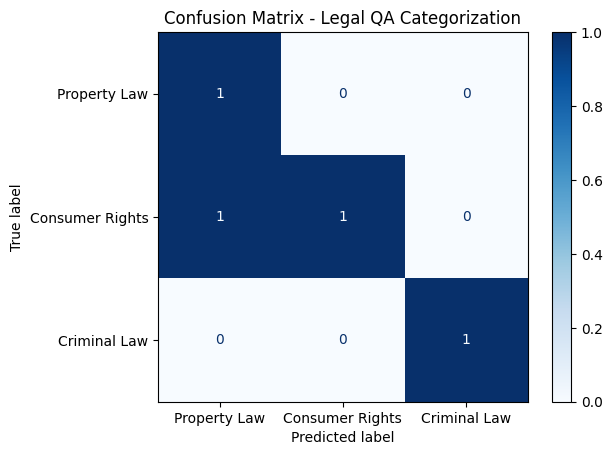

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = ["Property Law", "Consumer Rights", "Criminal Law", "Consumer Rights"]
predicted_labels = ["Property Law", "Consumer Rights", "Criminal Law", "Property Law"]

cm = confusion_matrix(true_labels, predicted_labels, labels=["Property Law", "Consumer Rights", "Criminal Law"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Property Law", "Consumer Rights", "Criminal Law"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Legal QA Categorization")
plt.show()


In [15]:
loader = PyPDFLoader("D:\ChatBot\Indian-Law-Chatbot\data\indian-penal-code.pdf")


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\jagde\AppData\Local\Temp\ipykernel_23028\2079005760.py:1: SyntaxWarning: invalid escape sequence '\C'
  loader = PyPDFLoader("D:\ChatBot\Indian-Law-Chatbot\data\indian-penal-code.pdf")


<>:10: SyntaxWarning: invalid escape sequence '\C'
<>:10: SyntaxWarning: invalid escape sequence '\C'
C:\Users\jagde\AppData\Local\Temp\ipykernel_23028\460825974.py:10: SyntaxWarning: invalid escape sequence '\C'
  loader = PyPDFLoader("D:\ChatBot\Indian-Law-Chatbot\data\indian-penal-code.pdf")  # Make sure the file exists


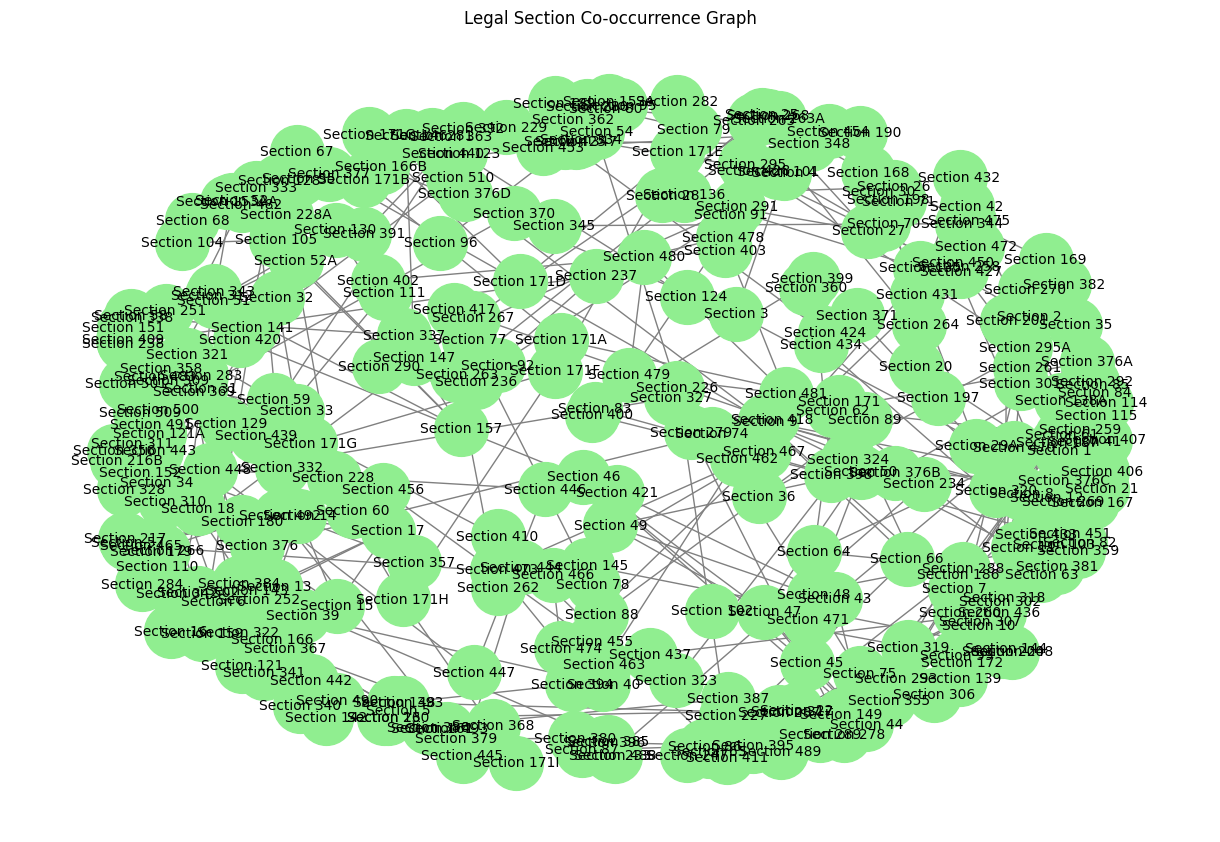

In [20]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# --- Load PDF (Keep your PDF file in the same folder or give full path) ---
loader = PyPDFLoader("D:\ChatBot\Indian-Law-Chatbot\data\indian-penal-code.pdf")  # Make sure the file exists
documents = loader.load()

# --- Split text into chunks ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_docs = text_splitter.split_documents(documents)

# --- Extract section relationships and build graph ---
def show_section_relation_graph(docs):
    section_cooccur = defaultdict(int)

    for doc in docs:
        found = re.findall(r'(Section|धारा|कलम)\s(\d+[A-Z]*)', doc.page_content)
        sections = [f"{s[0]} {s[1]}" for s in found]
        for pair in combinations(set(sections), 2):  # unique pairs
            section_cooccur[tuple(sorted(pair))] += 1

    G = nx.Graph()
    for (a, b), weight in section_cooccur.items():
        if weight >= 1:
            G.add_edge(a, b, weight=weight)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray',
            node_size=1500, font_size=10)
    plt.title("Legal Section Co-occurrence Graph")
    plt.show()

# --- Run the function on split documents ---
show_section_relation_graph(split_docs)
